# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn import model_selection
from sklearn import feature_selection

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import xgboost as xgb

from scipy.stats import spearmanr

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Loading data

In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [3]:
train_data = pd.read_csv(train_datalink_X)
test_data = pd.read_csv(hackathon_data_link)
train_targets = pd.read_csv(train_datalink_y)

In [4]:
train = train_data.merge(train_targets, left_index=True, right_index=True, how='inner')

In [5]:
# Define a list of the features to be used for the clustering
features = train_data.columns[train_data.columns.str.startswith('feature')]

# Metric / Scoring functions

In [6]:
def spearman(y_true, y_pred): 
    return spearmanr(y_pred, y_true).correlation

In [7]:
def score(X, y, model):
    score = np.mean(model_selection.cross_val_score(
            model,
            X,
            y,
            cv=cv,
            n_jobs=-1,
            # groups=moons,
            scoring=metrics.make_scorer(spearman, greater_is_better=True)))
    return score

# Model

In [8]:
model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=5, learning_rate=0.01, n_estimators=200, n_jobs=-1, colsample_bytree=0.5)

# CV

In [9]:
cv=model_selection.KFold(5, shuffle=True)

You might consider other Cross Validation for Time Series

In [10]:
X = train_data
y = train_targets.target_r

Your local CV score before Feature Engineering

In [11]:
score(X, y, model)

0.20866679302118185

# 1. K-Mean Clustering

The k-means algorithm is sensitive to scale. This means we need to be thoughtful about how and whether we rescale our features since we might get very different results depending on our choices.

## Cluster Label

In [12]:
# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=3, n_init=50, random_state=0)
X["Cluster"] = kmeans.fit_predict(X)

In [13]:
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,Cluster
0,0.25,0.25,0.0,0.0,0.50,0.0,0.25,1.0,0.0,0.0,0.0,0.25,0
1,0.75,0.75,0.0,0.0,0.25,0.0,1.00,1.0,0.0,0.0,0.0,0.00,0
2,0.50,0.50,0.0,0.0,0.75,0.0,0.00,0.0,0.0,0.0,1.0,0.00,1
3,1.00,1.00,0.0,0.0,0.50,0.0,1.00,1.0,0.0,0.0,0.0,0.00,0
4,0.25,0.25,0.0,0.0,0.25,0.0,0.50,1.0,0.0,0.0,0.0,0.00,0


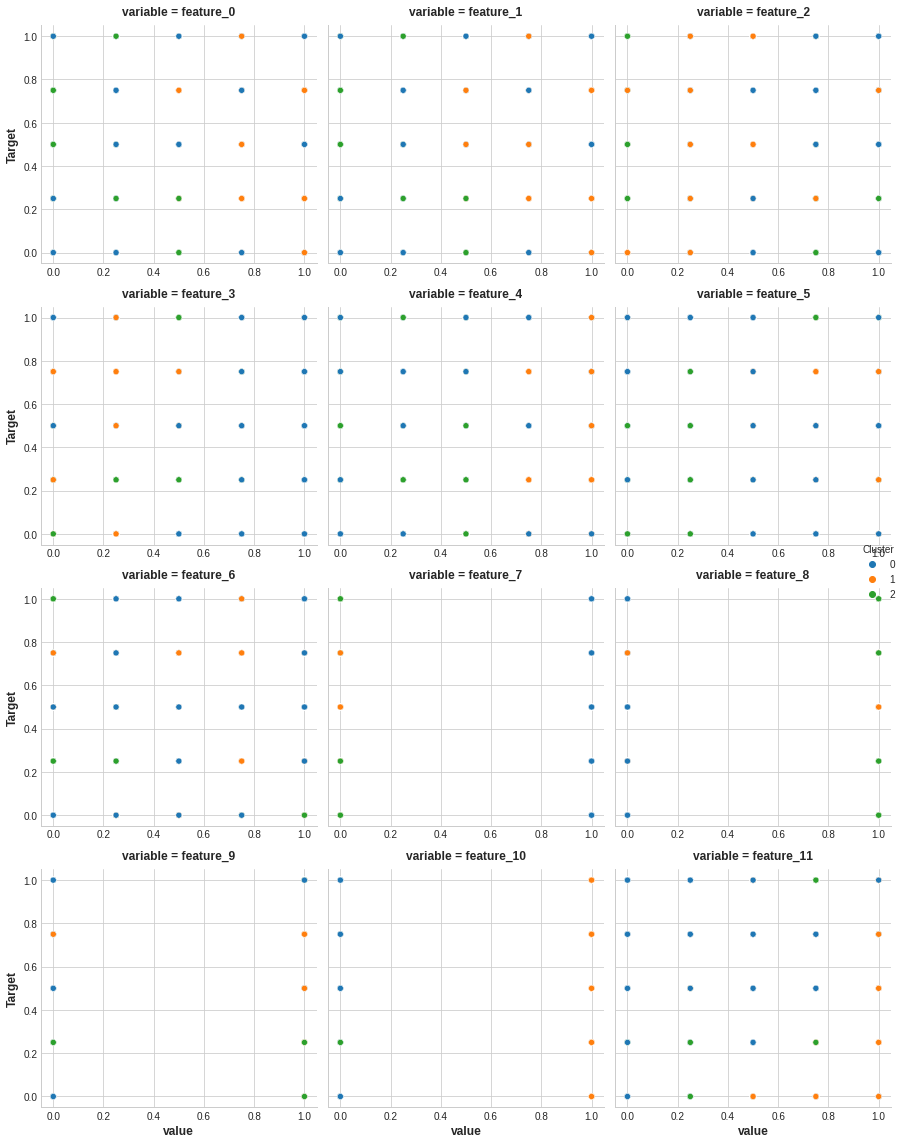

In [14]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["Target"] = y
sns.relplot(
    x="value", y="Target", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["Target", "Cluster"],
    ),
);


New CV score w/ Cluster Label

In [15]:
score(X, y, model)

0.2058448092098922



# Cluster-Distance Features

The k-means algorithm offers an alternative way of creating features. Instead of labelling each feature with the nearest cluster centroid, it can measure the distance from a point to all the centroids and return those distances as features.

In [16]:
kmeans = KMeans(n_clusters=3, n_init=50, random_state=0)

# Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X)

# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

In [17]:
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,Cluster,Centroid_0,Centroid_1,Centroid_2
0,0.25,0.25,0.0,0.0,0.50,0.0,0.25,1.0,0.0,0.0,0.0,0.25,0,2.538668,0.736134,2.070435
1,0.75,0.75,0.0,0.0,0.25,0.0,1.00,1.0,0.0,0.0,0.0,0.00,0,2.777237,0.949334,2.040560
2,0.50,0.50,0.0,0.0,0.75,0.0,0.00,0.0,0.0,0.0,1.0,0.00,1,1.997720,1.968979,1.653652
3,1.00,1.00,0.0,0.0,0.50,0.0,1.00,1.0,0.0,0.0,0.0,0.00,0,2.914306,1.119147,1.992916
4,0.25,0.25,0.0,0.0,0.25,0.0,0.50,1.0,0.0,0.0,0.0,0.00,0,2.564479,0.808797,2.166914


New CV score w/ Cluster Distances

In [18]:
score(X, y, model)

0.21360999176325798

# 2. Mutual Information

In [19]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = X.dtypes == int
    mi_scores = feature_selection.mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    color = np.array(["C0"] * scores.shape[0])
    # Color red for probes
    idx = [i for i, col in enumerate(scores.index)
           if col.startswith("PROBE")]
    color[idx] = "C3"
    # Create plot
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

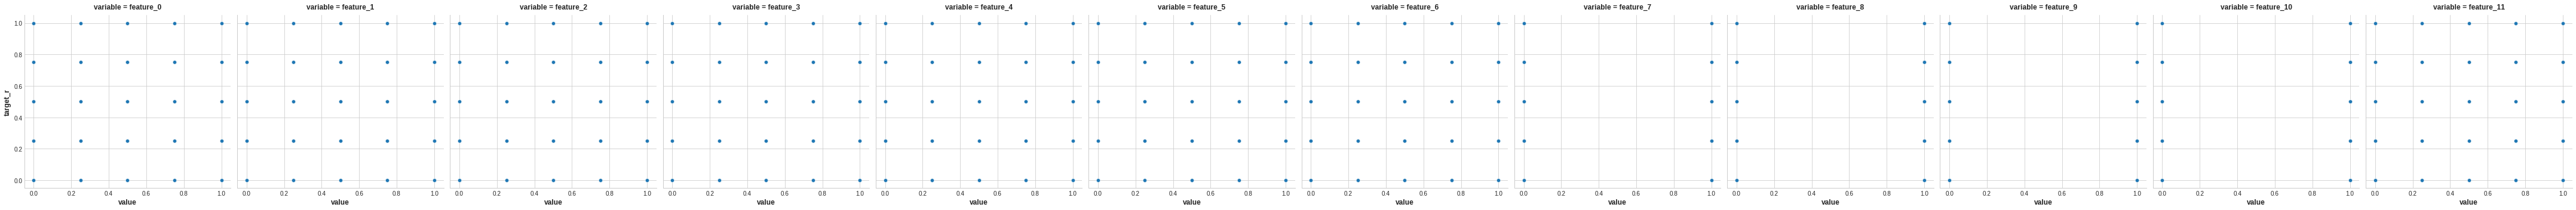

In [20]:
sns.relplot(
    x="value", y="target_r", col="variable", data=train.melt(id_vars="target_r", value_vars=features), facet_kws=dict(sharex=False),
);

In [21]:
mi_scores = make_mi_scores(X, y)

Centroid_0    0.176292
Centroid_2    0.162311
Centroid_1    0.153596
feature_2     0.012739
feature_0     0.012088
feature_3     0.011718
feature_4     0.011203
feature_6     0.007326
feature_10    0.007212
feature_11    0.003384
feature_1     0.002246
Cluster       0.001468
feature_5     0.000674
feature_9     0.000000
feature_8     0.000000
feature_7     0.000000
Name: MI Scores, dtype: float64


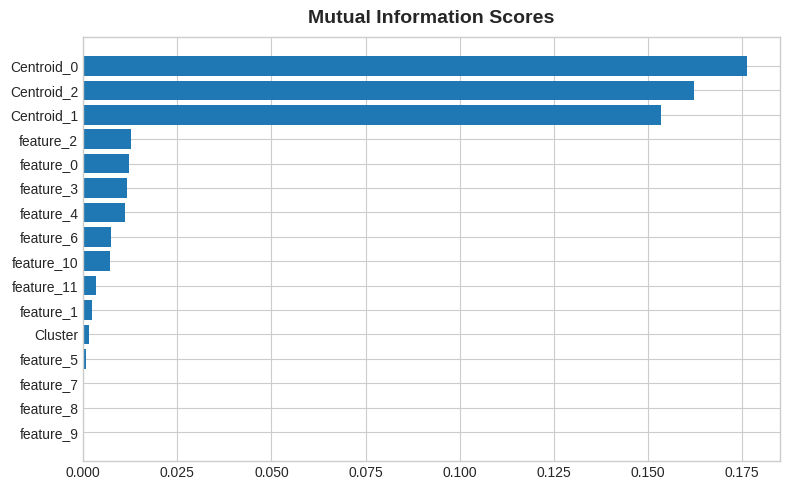

In [22]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

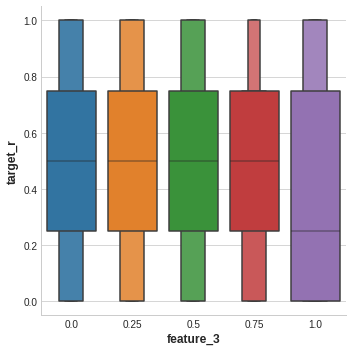

In [23]:
sns.catplot(x="feature_3", y="target_r", data=train, kind="boxen");

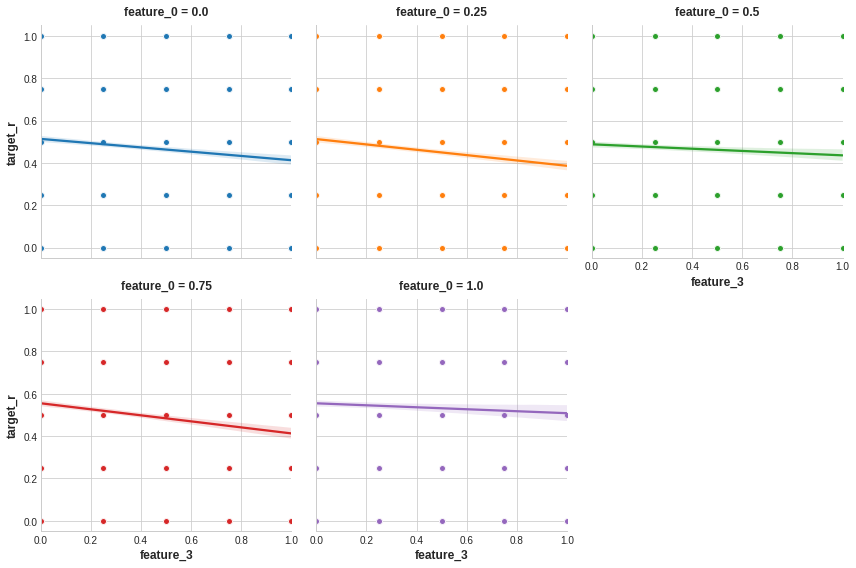

In [24]:
feature = "feature_3"

sns.lmplot(
    x=feature, y="target_r", hue="feature_0", col="feature_0",
    data=train, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect. Let's take a moment to make a list of features we might focus on. The goal is to build up a more informative feature set through combinations of the original features you identified as having high potential.

You found that the ten features with the highest MI scores were:

In [25]:
mi_scores.head(10)

Centroid_0    0.176292
Centroid_2    0.162311
Centroid_1    0.153596
feature_2     0.012739
feature_0     0.012088
feature_3     0.011718
feature_4     0.011203
feature_6     0.007326
feature_10    0.007212
feature_11    0.003384
Name: MI Scores, dtype: float64

As the data is obfuscated it's difficult to analyze the results. However combining these top features with other related features, especially those you've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train your model on.

#3. PCA

In [26]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [27]:
print("Correlation with Target_r:\n")
print(train[features].corrwith(train.target_r))

Correlation with Target_r:

feature_0     0.070269
feature_1     0.065870
feature_2     0.000256
feature_3    -0.105601
feature_4     0.053148
feature_5    -0.008493
feature_6     0.029310
feature_7    -0.007051
feature_8    -0.009717
feature_9    -0.014199
feature_10    0.039342
feature_11   -0.006184
dtype: float64


We'll rely on PCA to untangle the correlational structure of these features and suggest relationships that might be usefully modeled with new features.

In [28]:
# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                 PC1       PC2       PC3  ...      PC14      PC15          PC16
feature_0  -0.059098  0.461299 -0.049446  ...  0.094630  0.053190  7.953999e-16
feature_1  -0.051224  0.465400 -0.055296  ...  0.043608  0.062314 -9.305830e-16
feature_2  -0.007850 -0.006565  0.075750  ... -0.010855  0.005301 -1.184752e-16
feature_3  -0.039182 -0.094254  0.117720  ... -0.023878  0.004151  1.188826e-16
feature_4  -0.060795  0.451106  0.005370  ...  0.074146  0.052429 -6.473956e-17
feature_5   0.146761  0.132314  0.561580  ...  0.065269  0.008340 -2.121223e-16
feature_6  -0.166091  0.273704 -0.473749  ...  0.003476  0.052300 -2.394525e-16
feature_7  -0.425818 -0.106992  0.022491  ... -0.469067 -0.020901 -6.641922e-01
feature_8   0.394059  0.023635 -0.296142  ...  0.427019 -0.018991 -6.444847e-01
feature_9   0.021632  0.027957  0.047478  ...  0.022657  0.017572 -1.687587e-01
feature_10  0.074336  0.150717  0.495117  ...  0.095892  0.068283 -3.391293e-01
feature_11  0.080169  0.234988  0.270645

## Interpret Component Loadings

Look at the loadings for all components. Your goal is to use the results of PCA to discover one or more new features that improve the performance of your model. One option is to create features inspired by the loadings, like we did in the tutorial. Another option is to use the components themselves as features (that is, add one or more columns of `X_pca` to `X`).

## Create New Features using PCA

In [29]:
# Add new features to X.
X = X.join(X_pca)

score(X, y, model)

0.2306307510843178

In [30]:
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,Cluster,Centroid_0,Centroid_1,Centroid_2,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,0.25,0.25,0.0,0.0,0.50,0.0,0.25,1.0,0.0,0.0,0.0,0.25,0,2.538668,0.736134,2.070435,-1.976846,-1.483802,-0.418613,-1.158918,-0.358315,0.069457,-0.214612,-0.077930,-0.198147,-0.483693,1.098498,0.103916,-0.006885,0.047279,-0.042771,-2.775185e-14
1,0.75,0.75,0.0,0.0,0.25,0.0,1.00,1.0,0.0,0.0,0.0,0.00,0,2.777237,0.949334,2.040560,-2.500050,-0.012784,-1.732099,-0.952356,-0.626059,1.033095,0.041770,0.323410,0.739580,0.183381,-0.604807,0.048869,0.053250,-0.015205,0.024076,2.769302e-14
2,0.50,0.50,0.0,0.0,0.75,0.0,0.00,0.0,0.0,0.0,1.0,0.00,1,1.997720,1.968979,1.653652,0.831667,0.170489,1.316297,-1.501297,-1.453440,3.516840,-0.329211,-0.009637,-0.433265,-1.003974,1.618352,0.221290,-0.025427,0.035907,0.084528,-7.211781e-15
3,1.00,1.00,0.0,0.0,0.50,0.0,1.00,1.0,0.0,0.0,0.0,0.00,0,2.914306,1.119147,1.992916,-2.581592,1.025918,-1.788142,-0.840218,-0.699304,1.135940,0.252337,0.545042,1.025992,0.463341,-0.161950,0.202449,0.041371,-0.033669,0.052661,3.141544e-14
4,0.25,0.25,0.0,0.0,0.25,0.0,0.50,1.0,0.0,0.0,0.0,0.00,0,2.564479,0.808797,2.166914,-2.124267,-1.854142,-0.926081,-1.169836,-0.527116,0.564139,-0.105033,0.208748,-0.107201,-0.304582,0.245368,0.118871,0.011037,0.013406,-0.023385,1.808955e-15


You can also use PCA to detect outliers in the dataset (meaning, data points that are unusually extreme in some way). Outliers can have a detrimental effect on model performance, so it's good to be aware of them in case you need to take corrective action. PCA in particular can show you anomalous *variation* which might not be apparent from the original features. That's the kind of thing a principal component can show you.

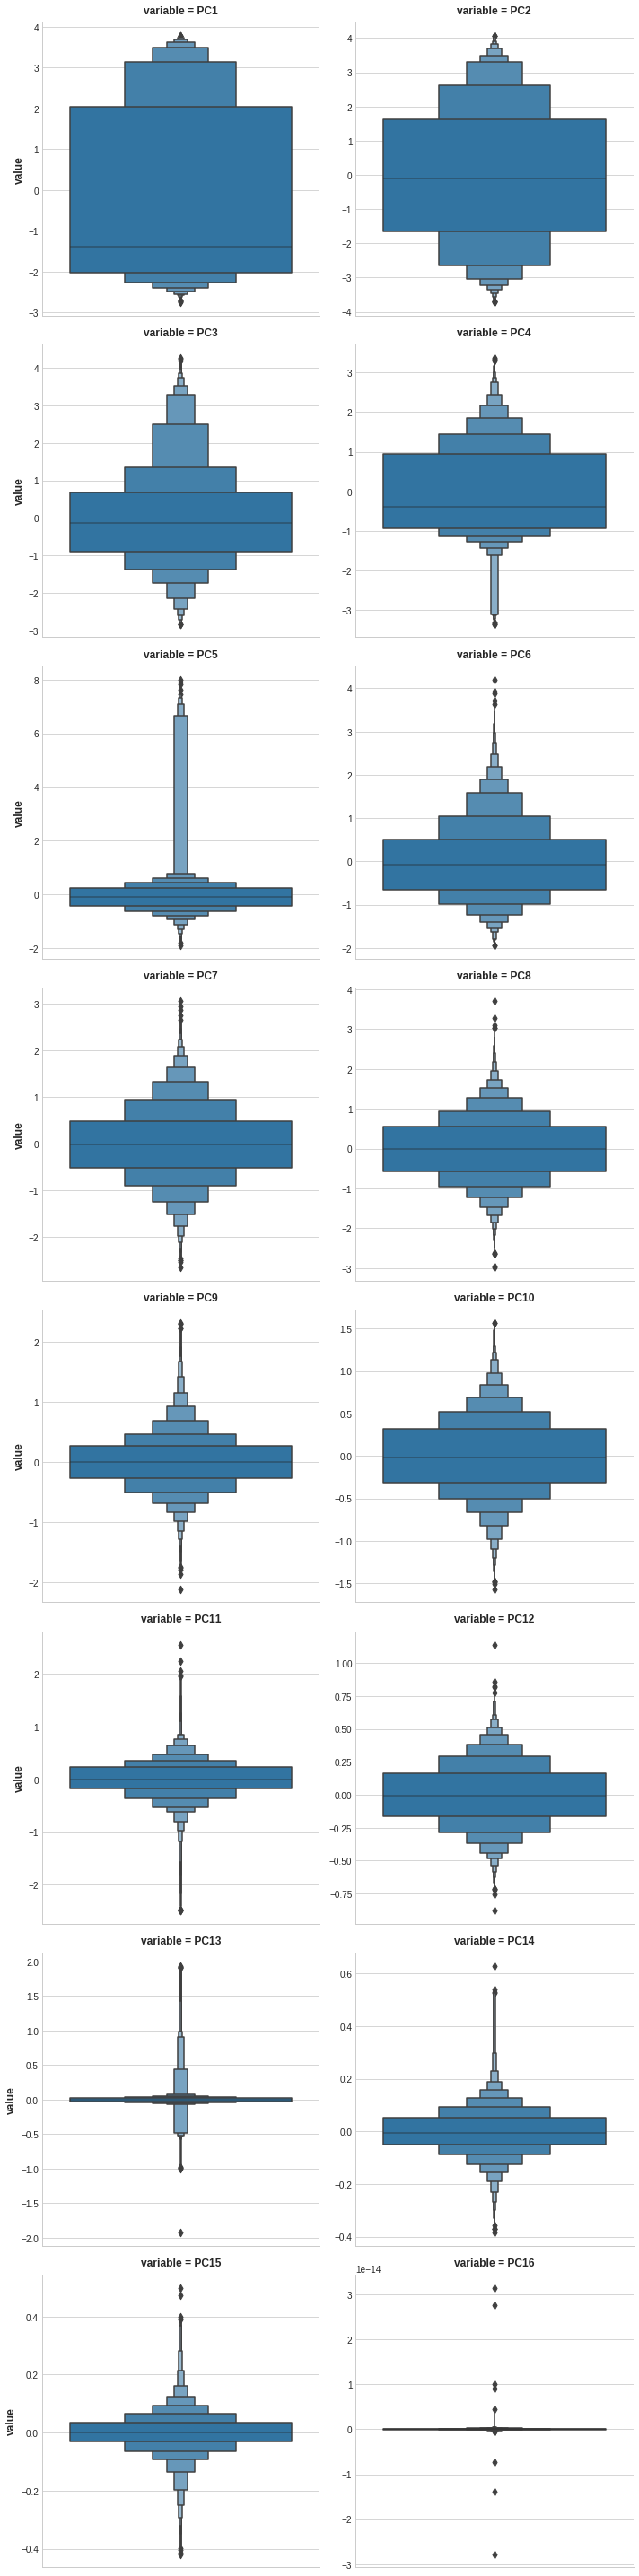

In [31]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers, that is.

# About
Last updated: 2021-03-03

Created by: [Jeremy Berros](https://github.com/jberros)

Greatly inspired by the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) Micro Course from [Ryan Holbrook](https://www.linkedin.com/in/ryan-holbrook-98b49a175/)